# 전이학습 (Transfer Learning)

* ref : https://codingcrews.github.io/2019/01/17/cat-dog/
* 기존에 잘 알려진 학습 모델을 가져와 사용
* CNN + FC (*.weight) 로 구성
* CNN 상위 레이어(5%), FC를 수정 후 신규 학습해 사용하는 것이 일반적

<img width='800' height='400' src = 'https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FH4rr7%2FbtqvBNchX4H%2FRmikaKBNm2N6VYD9JbI800%2Fimg.png'>

In [ ]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Dropout, Flatten, GlobalMaxPooling2D, AveragePooling2D
from keras.utils import to_categorical
from keras.datasets import fashion_mnist
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import array_to_img

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

ImportError: ignored

In [ ]:
np.random.seed(121)
tf.random.set_seed(121)

## 이지지 준비
* 이후 이미지 증강(Augmentation)을 위해 폴더 구조를 아래와 같이 둔다
<pre>
datasets
└── cats_and_dogs_small
    ├── test
    │   ├── cats
    │   │   └── datas...
    │   └── dogs
    │       └── datas...
    └── train
        ├── cats
        │   └── datas...
        └── dogs
            └── datas...
</pre>

# 공통 함수

In [ ]:
def myPlot(fit_res) :
    key_ = list(fit_res.history.keys())
    plt.figure(figsize=(12,5))
    for i in range(len(key_)):
        plt.plot(fit_res.history[key_[i]], label=key_[i])
    plt.title("metrics")
    plt.xlabel("epoch")
    plt.ylabel("score")
    plt.legend()
    plt.show()

In [ ]:
def myscore(X,y,fit_res=None):
    # test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=1)
    # print(f"loss: {test_loss:.5f} accuracy: {test_acc:.5f}" )
    history = model.evaluate(X,  y, verbose=1)
    print(f"loss: {history[0]:.5f} accuracy: {history[1]:.5f}" )
    if fit_res != None:
        myPlot(fit_res)
# myscore(test_images,  test_labels, fit_res)

In [ ]:
def myfit(X, y, SPLIT__=0.1, BATCH_SIZE__=128, EPOCHS__=10, ):
    fit_res = model.fit(X, y, batch_size=BATCH_SIZE__, epochs=EPOCHS__, validation_split=SPLIT__)
    return fit_res

In [ ]:
def mypredit_check(test_X, idx=0):
    pred = model.predict(test_X)
    print(pred[idx])
    pred_label = np.argmax(pred[idx])
    plt.title(f'{pred_label}, {LABEL_NAME__[pred_label]}')
    plt.imshow(test_X[idx])
    plt.show()

# 1. CNN Model Build

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense
from keras import layers
model = Sequential()
model.add(layers.InputLayer(input_shape=(64, 64, 3)))
model.add(layers.Conv2D(16, (3, 3), (1, 1), 'same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.3))

model.add(layers.Conv2D(32, (3, 3), (1, 1), 'same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.3))

model.add(layers.Conv2D(64, (3, 3), (1, 1), 'same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.3))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile( optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)       

### 데이터 증강

In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

rootPath = './datasets/cats_and_dogs_small'

imageGenerator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[.2, .2],
    horizontal_flip=True,
    validation_split=.1
)

trainGen = imageGenerator.flow_from_directory(
    os.path.join(rootPath, 'train'),
    target_size=(64, 64),
    subset='training'
)

validationGen = imageGenerator.flow_from_directory(
    os.path.join(rootPath, 'test'),
    target_size=(64, 64),
    subset='validation'
)

Found 450 images belonging to 2 classes.
Found 24 images belonging to 2 classes.


In [ ]:
trainGen.samples

450

### 모델 학습

In [ ]:
# 모델 저장 폴더
import os
if not os.path.exists("./model"):
    os.mkdir('./model')
    
filepath = "./model/{epoch:02d}{val_loss:.3f}.h5"
checkpnt = ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True)
estop = EarlyStopping(monitor='val_loss', patience=5)


In [ ]:
# myscore(test_images,  test_labels_cate, history)

In [ ]:
epochs = 45

history = model.fit(    # fit_generator(  deprecated
    trainGen, 
#     callbacks=[checkpnt,estop],
    epochs=epochs,
    steps_per_epoch=trainGen.samples / epochs, 
    validation_data=validationGen,
    validation_steps=trainGen.samples / epochs,
)

Epoch 1/45
10/10 [==============================] - 2s 151ms/step - loss: 0.6924 - acc: 0.5724 - val_loss: 0.6902 - val_acc: 0.7083
Epoch 2/45
10/10 [==============================] - 2s 152ms/step - loss: 0.6942 - acc: 0.4759 - val_loss: 0.6734 - val_acc: 0.7083
Epoch 3/45
10/10 [==============================] - 2s 178ms/step - loss: 0.6948 - acc: 0.4906 - val_loss: 0.6936 - val_acc: 0.4167
Epoch 4/45
10/10 [==============================] - 2s 152ms/step - loss: 0.6939 - acc: 0.4828 - val_loss: 0.6993 - val_acc: 0.2917
Epoch 5/45
10/10 [==============================] - 2s 153ms/step - loss: 0.6904 - acc: 0.5931 - val_loss: 0.6896 - val_acc: 0.5833
Epoch 6/45
10/10 [==============================] - 2s 164ms/step - loss: 0.6886 - acc: 0.5125 - val_loss: 0.6878 - val_acc: 0.5417
Epoch 7/45
10/10 [==============================] - 2s 180ms/step - loss: 0.6810 - acc: 0.5813 - val_loss: 0.6876 - val_acc: 0.4583
Epoch 8/45
10/10 [==============================] - 2s 159ms/step - loss: 0.

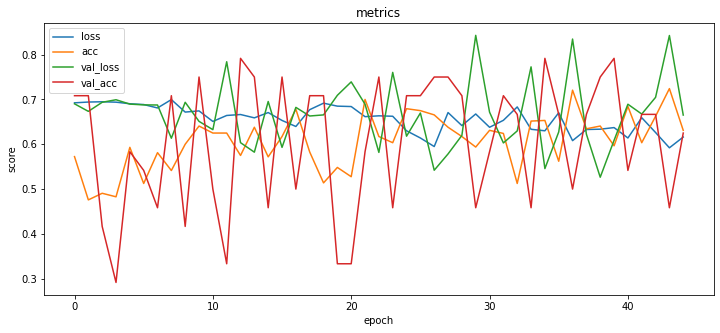

In [ ]:
myPlot(history)

## 예측 

In [ ]:
testGenerator = ImageDataGenerator( rescale=1./255 )

testGen = imageGenerator.flow_from_directory(
    os.path.join(rootPath, 'test'),
    target_size=(64, 64),
)
model.evaluate_generator(testGen)

Found 240 images belonging to 2 classes.


[0.6021203398704529, 0.6916666626930237]

## 예측모델 서비스

예측: 고양이
정답: 고양이


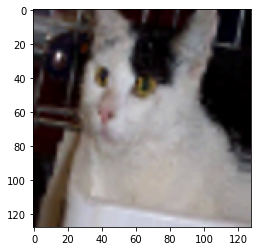

In [ ]:
cls_index = ['고양이', '개']

imgs = testGen.next()
arr = imgs[0][0]
img = array_to_img(arr).resize((128, 128))
plt.imshow(img)
result = model.predict_classes(arr.reshape(1, 64, 64, 3))
print('예측: {}'.format(cls_index[result[0]]))
print('정답: {}'.format(cls_index[np.argmax(imgs[1][0])]))


# 2. ResNet50 : 학습이 안된 관계로 전이학습 시행
* 비교적 가벼운 ResNet50 사용

<img src='model_compare.png'>

<img src='https://codingcrews.github.io/2019/01/19/cat-dog-resnet/residual.png'>

## 2-1. 방법1) CNN  +  FC 모두 사용 --> weight는 내 데이터로 학습 (학습 오래걸림)

In [ ]:
from keras.applications import ResNet50
model = Sequential()
model.add(ResNet50(include_top=True, weights=None, input_shape=(64, 64, 3), classes=2))

model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['acc'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2)                 23591810  
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
epochs = 45
history = model.fit_generator(
    trainGen, 
    epochs=epochs,
    steps_per_epoch=trainGen.samples / epochs, 
    validation_data=validationGen,
    validation_steps=trainGen.samples / epochs,
)

Epoch 1/45
10/10 [==============================] - 21s 2s/step - loss: 1.2608 - acc: 0.5955 - val_loss: 0.6841 - val_acc: 0.7083
Epoch 2/45
10/10 [==============================] - 12s 1s/step - loss: 1.2179 - acc: 0.5028
Epoch 3/45
10/10 [==============================] - 12s 1s/step - loss: 0.8475 - acc: 0.5440
Epoch 4/45
10/10 [==============================] - 12s 1s/step - loss: 0.8203 - acc: 0.5296
Epoch 5/45
10/10 [==============================] - 12s 1s/step - loss: 1.0366 - acc: 0.5227
Epoch 6/45
10/10 [==============================] - 12s 1s/step - loss: 1.5462 - acc: 0.5230
Epoch 7/45
10/10 [==============================] - 12s 1s/step - loss: 1.4290 - acc: 0.4886
Epoch 8/45
10/10 [==============================] - 13s 1s/step - loss: 1.1693 - acc: 0.5307
Epoch 9/45
10/10 [==============================] - 12s 1s/step - loss: 1.0962 - acc: 0.5503
Epoch 10/45
10/10 [==============================] - 12s 1s/step - loss: 1.1827 - acc: 0.5450
Epoch 11/45
10/10 [=============

In [ ]:
myPlot(history)

## ㅇㅖ측

In [ ]:
testGenerator = ImageDataGenerator(rescale=1./255)
testGen = imageGenerator.flow_from_directory(
    os.path.join(rootPath, 'test'),
    target_size=(64, 64),
)
model.evaluate_generator(testGen)


Found 240 images belonging to 2 classes.


[1.3403210639953613, 0.2874999940395355]

## 2-2. 방법2) CNN(전이학습 + ResNet Weight)  +  FC(신규, 내 데이터로 학습한 weight)  --> FC 학습시간 소요
* CNN 가중치는 imagenet 가중치 불러와서 사용
* include_top=False (FC는 신규생성해서 사용하겠다는 의미)
* 자신만의 FC구성해서 사용

In [ ]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(64, 64, 3))
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_57 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_57[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
model = Sequential()
model.add(base_model)  #===============include_top=False (FC는 신규생성해서 사용하겠다는 의미)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(126, activation='relu'))
model.add(layers.Dense(126, activation='relu'))         
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['acc'])
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_56  (None, 2048)              0         
_________________________________________________________________
dense_68 (Dense)             (None, 126)               258174    
_________________________________________________________________
dense_69 (Dense)             (None, 126)               16002     
_________________________________________________________________
dense_70 (Dense)             (None, 2)                 254       
Total params: 23,862,142
Trainable params: 23,809,022
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
epochs = 45
history = model.fit_generator(
    trainGen, 
    epochs=epochs,
    steps_per_epoch=trainGen.samples / epochs, 
    validation_data=validationGen,
    validation_steps=trainGen.samples / epochs,
)

Epoch 1/45
10/10 [==============================] - 21s 1s/step - loss: 0.7178 - acc: 0.6420 - val_loss: 1.5549 - val_acc: 0.7083
Epoch 2/45
10/10 [==============================] - 14s 1s/step - loss: 0.5992 - acc: 0.7178
Epoch 3/45
10/10 [==============================] - 13s 1s/step - loss: 0.5394 - acc: 0.7433
Epoch 4/45
10/10 [==============================] - 13s 1s/step - loss: 0.4371 - acc: 0.7948
Epoch 5/45
10/10 [==============================] - 13s 1s/step - loss: 0.4362 - acc: 0.8082
Epoch 6/45
10/10 [==============================] - 13s 1s/step - loss: 0.4470 - acc: 0.8204
Epoch 7/45
10/10 [==============================] - 15s 2s/step - loss: 0.4312 - acc: 0.8172
Epoch 8/45
10/10 [==============================] - 15s 1s/step - loss: 0.4401 - acc: 0.8755
Epoch 9/45
10/10 [==============================] - 13s 1s/step - loss: 0.2749 - acc: 0.8749
Epoch 10/45
10/10 [==============================] - 15s 1s/step - loss: 0.3508 - acc: 0.8591
Epoch 11/45
10/10 [=============

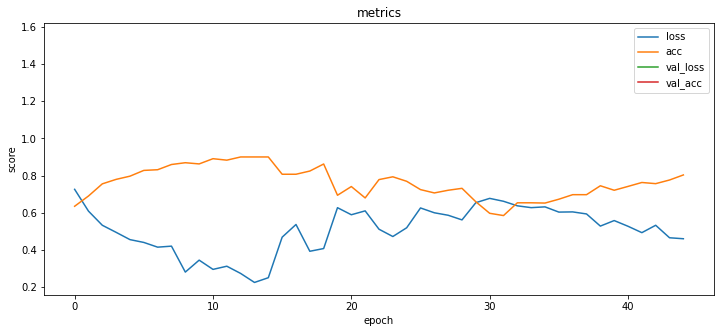

In [ ]:
myPlot(history)

### 예측

In [ ]:
testGenerator = ImageDataGenerator(rescale=1./255)
testGen = imageGenerator.flow_from_directory(
    os.path.join(rootPath, 'test'),
    target_size=(64, 64),
)
model.evaluate_generator(testGen)

Found 240 images belonging to 2 classes.


[2.2299766540527344, 0.2916666567325592]

## 2-3. 방법3) Fine Tuning 
* CNN(대부부분사용+ ResNet Weight) + CNN(일부사용+내 데이터로 학습한 weight) + FC(신규, 내 데이터로 학습한 weight)  --> CNN일부, FC 학습시간 소요

* 과부하 주의 ~!!!!   GPU 사용 권장
* CNN 마지막 일부 레이어들의 가중치만 수정되도록 학습(미세조정)
* 학습에 참여하는 레이어를 제외한 모델의 모든 레이어는 가중치를 업데이트 되지 않도록 동결(Freeze)  <---- 주의주의주의

In [ ]:
model.trainable = False
# gap = layers.GlobalAveragePooling2D()(base_model.output)

for i, layer in enumerate(base_model.layers):
    if layer.name == 'conv5_block1_1_conv':
        print(i) 
    
        
# # 마지막 143번째 뒤 레이어들만 학습
for l in base_model.layers[143:]:
    l.trainable = True

    
print(base_model.get_layer('conv5_block1_1_conv').name,  base_model.layers[143])
# conv5_block2_1_conv (Conv2D)    (None, 2, 2, 512)    1049088     conv5_block1_out[0][0] 
base_model = base_model.get_layer('conv5_block1_1_conv')
    
    
    
# # headModel = baseModel.output
# headModel = AveragePooling2D(pool_size=(2, 2))(base_model.output)
# headModel = Flatten(name="flatten")(headModel)
# headModel = Dense(256, activation="relu")(headModel)
# headModel = Dropout(0.5)(headModel)
# headModel = Dense(1, activation="sigmoid")(headModel)

# # # # x = GlobalMaxPooling2D()(last_output)
# # # # x = Dense(512, activation='relu')(x)
# # # # x = Dropout(0.5)(x)
# # # # x = layers.Dense(1, activation='sigmoid')(x)

# model = Model(base_model.input, headModel)    
# model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['acc'])
# model.summary()


143
conv5_block1_1_conv <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001DF5FC7FD60>


### 학습

In [ ]:
print(trainGen.samples, validationGen.samples)

450 24


In [ ]:
epochs = 135
history = model.fit_generator(
    trainGen, 
    epochs=epochs,
    steps_per_epoch=trainGen.samples / epochs, 
    validation_data=validationGen,
    validation_steps=validationGen.samples /24
)

Epoch 1/135
3/3 [==============================] - 1s 389ms/step - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 2/135
3/3 [==============================] - 1s 349ms/step - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 3/135
3/3 [==============================] - 1s 379ms/step - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 4/135
3/3 [==============================] - 1s 339ms/step - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 5/135
3/3 [==============================] - 1s 394ms/step - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 6/135
3/3 [==============================] - 1s 332ms/step - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 7/135
3/3 [==============================] - 1s 409ms/step - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 8/135
3/3 [==============================] - 1s 403ms/step - loss: 0.6931 - a

KeyboardInterrupt: 

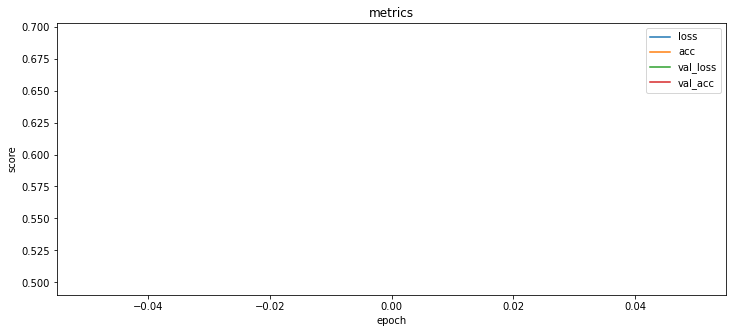

In [ ]:
myPlot(history)

### 예측

In [ ]:
testGenerator = ImageDataGenerator(rescale=1./255)
testGen = imageGenerator.flow_from_directory(
    os.path.join(rootPath, 'test'),
    target_size=(64, 64),
)
model.evaluate_generator(testGen)

Found 240 images belonging to 2 classes.


[0.6931471228599548, 0.5]